In [2]:
!pip install numpy pandas matplotlib pillow tqdm torch torchvision scikit-learn tensorflow


  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.0-cp312-cp312-win_amd64.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached scipy-1.15.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached 

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
image_path="./rps-cv-images"

#### removing corrupted_images
for category in os.listdir(folder_path):

*  It loops through each subfolder in the main folder (e.g., rock, paper, scissors).

for img_file in os.listdir(category_path):

*  It then loops through every image in that subfolder.

img = Image.open(img_path)

*  Tries to open the image using Pillow (PIL). This checks if the image can be read.

img.verify()

*  This verifies the image is not corrupted or partially downloaded. It does not load the image into memory (it’s lightweight).

If it fails (IOError or SyntaxError)

*   That means the image is likely corrupted (damaged file, wrong format, etc.).

*   It prints the path of the bad image and deletes it using os.remove(img_path).

In [5]:
def remove_corrupted_images(image_path):
    for category in os.listdir(image_path):
        category_path = os.path.join(image_path, category)
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print("Removing corrupted image:", img_path)
                os.remove(img_path)


In [6]:
remove_corrupted_images("rps-cv-images")

#### Loading the data 
Load all the images (rock, paper, scissors) from folders, resize them to 64×64 pixels, normalize their pixel values, automatically assign labels based on folder names, and split them into training and validation sets.
rescale=1./255 → Scales image pixel values from range [0, 255] to [0, 1] (which helps the neural network train better).
validation_split=0.2 → Splits your dataset: 80% for training, 20% for validation
##### loading the training data 
'rps-cv-images' → Path to the main folder that contains the rock/, paper/, and scissors/ folders.
target_size=(64, 64) → Resizes all images to 64×64 pixels.
batch_size=32 → Loads 32 images at a time (good for memory efficiency).
class_mode='categorical' → Labels are one-hot encoded. So if the classes are rock, paper, scissors, each image label looks like:

Rock → [1, 0, 0]

Paper → [0, 1, 0]

Scissors → [0, 0, 1]
subset='training' → This line tells it to use 80% of the data for training (from the split defined above).

##### loading the validation data 
It uses the remaining 20% of images (subset='validation').

In [8]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    image_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical",
    subset="training",
)

val_generator = datagen.flow_from_directory(
    image_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [9]:
src = 'rps-cv-images'
dst = 'rps-split'
splits = ['train', 'val', 'test']

for label in os.listdir(src):
    files = os.listdir(os.path.join(src, label))
    train, temp = train_test_split(files, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    
    for split, split_list in zip(splits, [train, val, test]):
        os.makedirs(os.path.join(dst, split, label), exist_ok=True)
        for f in split_list:
            shutil.copy(
                os.path.join(src, label, f),
                os.path.join(dst, split, label, f)
            )


In [10]:
train_gen = datagen.flow_from_directory('rps-split/train', target_size=(64, 64), class_mode='categorical')
val_gen = datagen.flow_from_directory('rps-split/val', target_size=(64, 64), class_mode='categorical')
test_gen = datagen.flow_from_directory('rps-split/test', target_size=(64, 64), class_mode='categorical', shuffle=False)


Found 1531 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 329 images belonging to 3 classes.


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = 224
DATA_DIR = "rps-split"

In [12]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [13]:
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [14]:
class MulticlassClassifier(nn.Module):
    def __init__(self):
        super(MulticlassClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # 224x224 -> 112x112
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),  # 112x112 -> 56x56
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.model(x)


In [15]:
def train_model(optimizer_name):
    model = MulticlassClassifier().to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = train_loss / total
        epoch_train_acc = correct / total

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = correct_val / total_val

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        print(f"[{optimizer_name}] Epoch {epoch+1}/{EPOCHS} => "
              f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


Training with SGD...

[SGD] Epoch 1/10 => Train Acc: 0.5330 | Val Acc: 0.7470
[SGD] Epoch 2/10 => Train Acc: 0.7400 | Val Acc: 0.7896
[SGD] Epoch 3/10 => Train Acc: 0.8334 | Val Acc: 0.8262
[SGD] Epoch 4/10 => Train Acc: 0.8452 | Val Acc: 0.8902
[SGD] Epoch 5/10 => Train Acc: 0.8975 | Val Acc: 0.9024
[SGD] Epoch 6/10 => Train Acc: 0.9151 | Val Acc: 0.8963
[SGD] Epoch 7/10 => Train Acc: 0.9223 | Val Acc: 0.9268
[SGD] Epoch 8/10 => Train Acc: 0.9393 | Val Acc: 0.9451
[SGD] Epoch 9/10 => Train Acc: 0.9477 | Val Acc: 0.9268
[SGD] Epoch 10/10 => Train Acc: 0.9556 | Val Acc: 0.9543

Training with Adam...

[Adam] Epoch 1/10 => Train Acc: 0.5493 | Val Acc: 0.7896
[Adam] Epoch 2/10 => Train Acc: 0.8844 | Val Acc: 0.8872
[Adam] Epoch 3/10 => Train Acc: 0.9438 | Val Acc: 0.9299
[Adam] Epoch 4/10 => Train Acc: 0.9726 | Val Acc: 0.9451
[Adam] Epoch 5/10 => Train Acc: 0.9824 | Val Acc: 0.9512
[Adam] Epoch 6/10 => Train Acc: 0.9922 | Val Acc: 0.9604
[Adam] Epoch 7/10 => Train Acc: 0.9987 | Val Acc: 

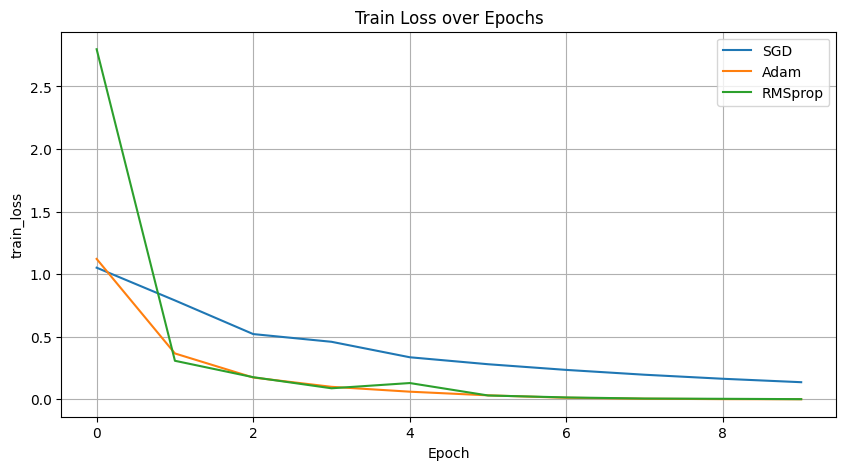

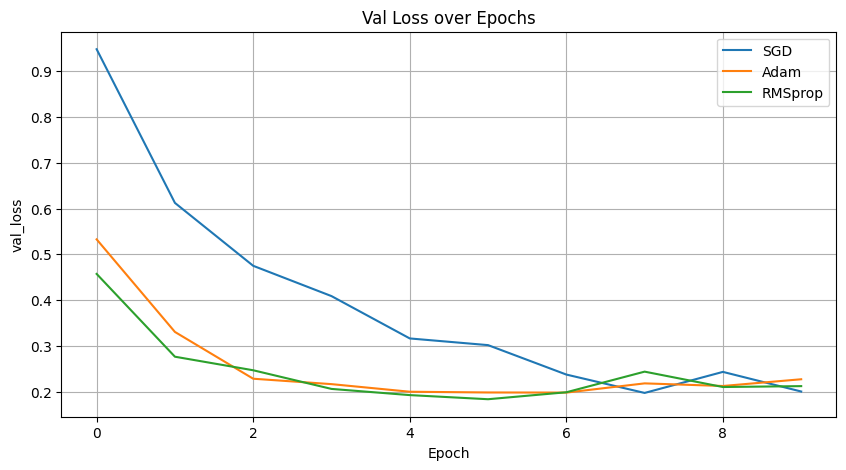

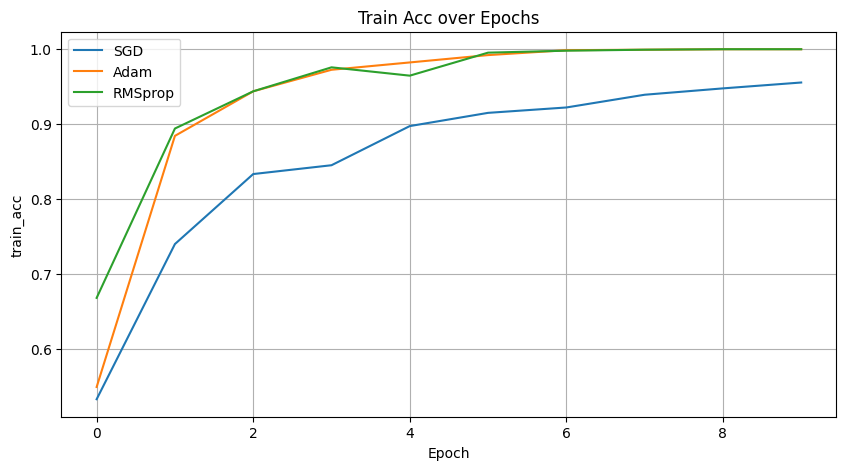

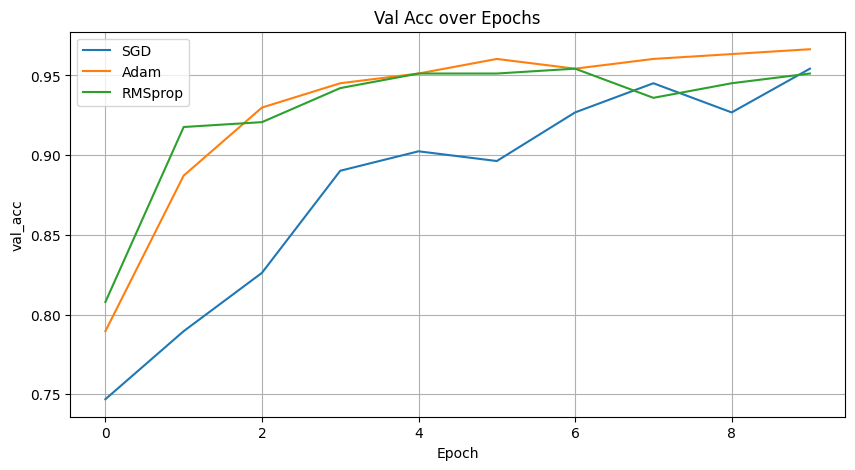

In [16]:
results = {}
for opt_name in ['SGD', 'Adam', 'RMSprop']:
    print(f"\nTraining with {opt_name}...\n")
    losses, val_losses, accs, val_accs = train_model(opt_name)
    results[opt_name] = {
        "train_loss": losses,
        "val_loss": val_losses,
        "train_acc": accs,
        "val_acc": val_accs
    }

# ===============================
# 7. Plot Results
# ===============================
def plot_metrics(metric_name):
    plt.figure(figsize=(10, 5))
    for opt in results:
        plt.plot(results[opt][metric_name], label=opt)
    plt.title(f"{metric_name.replace('_', ' ').title()} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics("train_loss")
plot_metrics("val_loss")
plot_metrics("train_acc")
plot_metrics("val_acc")